# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

## Preliminary step: Install and Import Libraries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import torch
import torchaudio
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

## Loading of the Model and Device Selection

In [3]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [4]:
device

device(type='mps')

## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [5]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [6]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start

In [7]:
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold

In [8]:
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm.tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict

In [9]:
def load_dataset():
    """
    Load the dataset from the musdb18hq_trimmed folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm.tqdm(os.listdir("musdb18hq_trimmed")):
        track_path = os.path.join("musdb18hq_trimmed", track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

Function that creates the new mixture and save it in the dictionary

In [10]:
def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the musdb18hq_trimmed folder.
    """
    for track_folder, stems_dict in tqdm.tqdm(dataset_dict.items()):
    
        track_path = os.path.join("musdb18hq_trimmed", track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform*0.25

        # Normalize the new_mixture to 1
        new_mixture = new_mixture / torch.max(torch.abs(new_mixture))
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")

In [11]:
if os.path.isdir("musdb18hq_trimmed"):
    print("Dataset already exists.")
    # Load the trimmed dataset
    dataset_dict = load_dataset()
    print("Dataset loaded.")
else:
    print("Loading dataset...")
    dataset_dict = load_and_process_dataset()
    print("Dataset loaded.")
    
    # Save the trimmed dataset
    os.makedirs("musdb18hq_trimmed", exist_ok=True)
    create_dataset(dataset_dict)

    print("Trimmed dataset saved.")

Dataset already exists.


100%|██████████| 50/50 [00:00<00:00, 54.88it/s]

Dataset loaded.


Trimmed tracks check

In [12]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
for stem_name in dataset_dict[first_track_folder].keys():
    print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")


Number of keys in dataset_dict: 50
First track folder: Moosmusic - Big Dummy Shake
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


Function to separate the sources


In [13]:
def separate_sources(
    model,
    mix,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None,
    normalize=True,
):
    """
    Separate sources from a mixture using the provided model.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources, channels, length).
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

Save the new DATASET FOLDER

In [14]:
# New dataset folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed"

Evaluation of the results

In [15]:
def evaluate_sdr(original_stem: torch.Tensor, predicted_stem: torch.Tensor, device: torch.device=None):
    """
    Calculate the Scale-Invariant Signal-to-Distortion Ratio (SDR) between the original and predicted stems.

    Args:
        original_stem (torch.Tensor): The original stem waveform (shape: [channels, samples]).
        predicted_stem (torch.Tensor): The predicted stem waveform (shape: [channels, samples]).

    Returns:
        float: The SDR value.
    """
    # Ensure both tensors are on the same device
    original_stem.to(device)
    predicted_stem.to(device)
    
    # Initialize the SDR metric
    sdr_metric = ScaleInvariantSignalDistortionRatio().to(device)

    # Compute the SDR
    sdr_value = sdr_metric(predicted_stem, original_stem).item()

    return sdr_value

Evaluation of the model in standard usage

In [16]:
def evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, segment_length, device, normalize):
    """
    Evaluate the SDR for each track in the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        segment_length: Length of each segment in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    for track_name, stems_dict in dataset_dict.items():
        print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform source separation
        separated_sources = separate_sources(model, mixture[:, :, :segment_length * sample_rate], sample_rate=sample_rate, device=device, normalize=normalize)

        # Evaluate SDR for each stem
        for i, stem_name in enumerate(model.sources):
            if stem_name in stems_dict:
                original_stem = stems_dict[stem_name].to(device)
                predicted_stem = separated_sources[0, i].to(device)

                # Calculate SDR
                sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)
                sdr_results[stem_name].append(sdr_value)
                print(f"SDR for {stem_name} in track {track_name}: {sdr_value:.2f} dB")

    # Calculate the average SDR for each stem
    average_sdr = {stem: (np.mean(values) if values else None) for stem, values in sdr_results.items()}

    print("\nAverage SDR for each stem:")
    for stem, avg_sdr in average_sdr.items():
        print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")

    return average_sdr

Testing the effect of the volume on the SDR on the same stem

In [17]:
track_names = list(dataset_dict.keys())

track_chosen = track_names[25]

# Retrieve the original "new_mixture" waveform from the specified track
original_stem_test = dataset_dict[track_chosen]["vocals"]

# Create a new version with a different volume 
different_vol_stem_test = original_stem_test * 0.6

print(f"Original stem shape: {original_stem_test.shape}")
print(f"Different volume stem shape: {different_vol_stem_test.shape}")

# Evaluate SDR when comparing the original stem to itself 
sdr_original = evaluate_sdr(original_stem_test, original_stem_test)

# Evaluate SDR when comparing the scaled stem to the original
sdr_different = evaluate_sdr(original_stem_test, different_vol_stem_test)

print(f"SDR for original volume vs. itself: {sdr_original:.2f} dB")
print(f"SDR for different volume vs. original: {sdr_different:.2f} dB")

Original stem shape: torch.Size([2, 1323000])
Different volume stem shape: torch.Size([2, 1323000])
SDR for original volume vs. itself: 105.44 dB
SDR for different volume vs. original: 101.00 dB


Function to plot the average SDR across all the stems in the dataset

In [18]:
def plot_sdr_results(sdr_results):
    """
    Plot the SDR results for each stem.

    Args:
        sdr_results (dict): Dictionary containing the average SDR for each stem.
    """
    stems = list(sdr_results.keys())
    sdr_values = [sdr_results[stem] for stem in stems]

    plt.figure(figsize=(10, 5))
    plt.bar(stems, sdr_values, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Stem')
    plt.ylabel('Average SDR (dB)')
    plt.title('Average SDR for Each Stem')
    plt.ylim([0, max(sdr_values) + 5])
    plt.grid(axis='y')
    plt.show()

In [19]:
# Evaluate SDR across the dataset using the provided function using no normalization.
average_sdr = evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, SEGMENT_LENGTH, device, normalize=False)
print("Average SDR results per stem:", average_sdr)

Processing track: Moosmusic - Big Dummy Shake
SDR for drums in track Moosmusic - Big Dummy Shake: 10.66 dB
SDR for bass in track Moosmusic - Big Dummy Shake: 10.10 dB
SDR for other in track Moosmusic - Big Dummy Shake: 7.11 dB
SDR for vocals in track Moosmusic - Big Dummy Shake: 11.06 dB
Processing track: The Mountaineering Club - Mallory
SDR for drums in track The Mountaineering Club - Mallory: 14.67 dB
SDR for bass in track The Mountaineering Club - Mallory: 10.87 dB
SDR for other in track The Mountaineering Club - Mallory: 6.30 dB
SDR for vocals in track The Mountaineering Club - Mallory: 13.20 dB
Processing track: Bobby Nobody - Stitch Up
SDR for drums in track Bobby Nobody - Stitch Up: 8.64 dB
SDR for bass in track Bobby Nobody - Stitch Up: 9.46 dB
SDR for other in track Bobby Nobody - Stitch Up: 5.80 dB
SDR for vocals in track Bobby Nobody - Stitch Up: 10.13 dB
Processing track: Punkdisco - Oral Hygiene
SDR for drums in track Punkdisco - Oral Hygiene: 16.67 dB
SDR for bass in tra

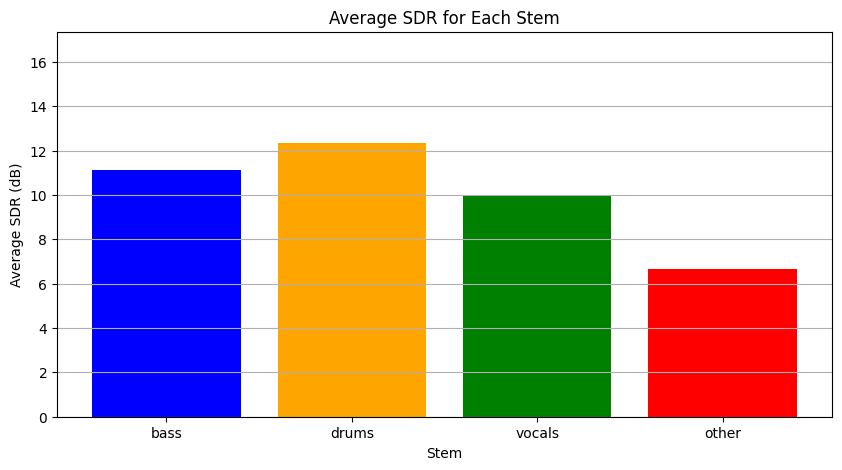

In [20]:
# Plot the SDR results
plot_sdr_results(average_sdr)

## Motivation

Starting from an Oracle Predictor 

In [56]:
def schedule(initial_gains, step, steps, target_stem, schedule_type):
    """
    Create a schedule for the target stem's gain based on the specified schedule type.

    Args:
        initial_gains (dict): Dictionary of initial gains for each stem.
        step (int): The current step in the schedule.
        steps (int): The total number of steps in the schedule.
        target_stem (str): The stem to which the schedule is applied.
        schedule_type (str): The type of schedule ('linear', 'exponential', or 'constant').

    Returns:
        dict: Updated gains for each stem.
    """
    if schedule_type == "linear":
        # Linear 
        next_value = initial_gains[target_stem] * (1 + step / steps)
    elif schedule_type == "exponential":
        # Exponential
        next_value = initial_gains[target_stem] * np.exp(step / steps)
    elif schedule_type == "constant":
        # Constant
        next_value = initial_gains[target_stem]
    else:
        raise ValueError("Invalid schedule type. Choose from 'linear', 'exponential', or 'constant'.")

    # Update the target stem's gain
    updated_gains = initial_gains.copy()
    updated_gains[target_stem] = next_value

    # Normalize the gains
    total_gain = sum(updated_gains.values())
    for stem in updated_gains:
        updated_gains[stem] /= total_gain

    return updated_gains

In [29]:
def progressive_inference(
    model,
    mix,
    target_stem,
    reference_stems,
    initial_gains,
    sample_rate,
    overlap=0.0, 
    device=None,
    normalize=True,
    steps=10,
    schedule_type="linear",
    checkSDREachStep=False,
):
    """
    Perform progressive inference on the mixture using the specified model and schedule.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        target_stem: The target stem to be enhanced.
        reference_stems: Dictionary of reference stems for evaluation.
        initial_gains: Initial gains for each stem.
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
    Returns:
        separated_sources: The separated sources tensor (batch, sources, channels, length).
        sdr_results: Dictionary containing SDR results for each stem.
    """

    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    separated_sources = separate_sources(model, mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

    if(checkSDREachStep):
        for i, stem_name in enumerate(model.sources):
            original_stem = reference_stems[stem_name].to(device)
            predicted_stem = separated_sources[0, i].to(device)

            # Calculate SDR
            sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)

            # save the SDR value in a dictionary
            sdr_results[stem_name].append(sdr_value)


    # Schedule
    for step in range(steps - 1):
        # update the gains
        gains = schedule(initial_gains, step, steps, target_stem=target_stem, schedule_type=schedule_type)
        
        # create the new mixture and apply the gains to the separated sources
        new_mix = torch.zeros_like(mix)
        for i, stem_name in enumerate(model.sources):
            new_mix += separated_sources[:, i] * gains[stem_name]

        # separate the new mixture
        separated_sources = separate_sources(model, new_mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

        if(checkSDREachStep or step == steps - 2):
            # evaluate SDR for each stem
            for i, stem_name in enumerate(model.sources):
                original_stem = reference_stems[stem_name].to(device)
                predicted_stem = separated_sources[0, i].to(device)

                # Calculate SDR
                sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)

                # save the SDR value in a dictionary
                sdr_results[stem_name].append(sdr_value)
                

    return separated_sources, sdr_results


In [ ]:
def progressive_inference_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    segment_length,
    device,
    normalize,
    target_stem="vocals",
    steps=10,
    schedule_type="linear",
    overlap=0.0,
    initial_gains=None,
):
    """
    Perform progressive inference across the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        segment_length: Length of each segment in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        overlap: Overlap between segments in seconds.
        initial_gains: Initial gains for each stem.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    if initial_gains is None:
        initial_gains = {stem: 0.25 for stem in ["bass", "drums", "vocals", "other"]}

    sdr_collection_dict = [] # tensor to store SDR results for each track

    for track_name, stems_dict in tqdm.tqdm(dataset_dict.items()):

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform progressive inference
        separated_sources, sdr_results_single_track = progressive_inference(
            model,
            mixture[:, :, :segment_length * sample_rate],
            target_stem=target_stem,
            reference_stems=stems_dict,
            initial_gains=initial_gains,
            sample_rate=sample_rate,
            overlap=overlap,
            device=device,
            normalize=normalize,
            steps=steps,
            schedule_type=schedule_type,
            checkSDREachStep=True,
        )
        
        # Convert sdr_results_single_track to a tensor
        sdr_tensor = torch.tensor([sdr_results_single_track[stem] for stem in ["bass", "drums", "vocals", "other"]])

        # Append the SDR tensor to the collection
        sdr_collection_dict.append(sdr_tensor)
        sdr_collection = torch.stack(sdr_collection_dict)
         
    
    # Evaluate the mean SDR for each stem
    sdr_collection_mean = torch.mean(sdr_collection, dim=0)
    
    return sdr_collection_mean


In [25]:
# reduce to 10 tracks the dataset_dict
dataset_dict_reduced = {k: dataset_dict[k] for k in list(dataset_dict)[:10]}

In [57]:
# use the function to evaluate SDR across all the dataset using progressive inference
average_sdr = progressive_inference_across_dataset(
    dataset_dict_reduced,
    model,
    sample_rate,
    SEGMENT_LENGTH,
    device,
    target_stem="vocals",
    normalize=True,
    steps=10,
    schedule_type="linear",
    overlap=0.0,
    initial_gains={"bass": 0.25, "drums": 0.25, "vocals": 0.25, "other": 0.25},
)


100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


In [58]:
# print average SDR results
print("Average SDR results per stem:", average_sdr)

Average SDR results per stem: tensor([[  9.0054,   8.8983,   8.6865,   8.3919,   7.9788,   7.1475,   4.8278,
          -3.2280,  -6.5971, -10.3218],
        [ 11.3229,  11.1944,  10.9955,  10.7094,  10.3162,   9.7754,   8.8735,
           7.9193,   6.6194,   0.2240],
        [ 10.0908,   9.9822,   9.8550,   9.7004,   9.5220,   9.3389,   9.1801,
           9.0566,   8.9699,   8.8973],
        [  6.8192,   6.7264,   6.5411,   6.2489,   5.8068,   5.1035,   3.9682,
           2.4591,   0.9731,  -1.3880]])


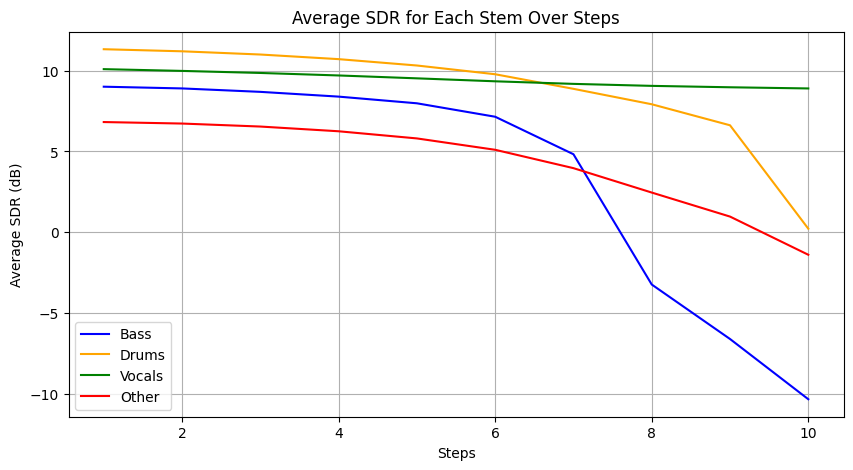

In [59]:
# Convert average_sdr tensor to a dictionary with numpy values
average_sdr_dict = {
    "bass": average_sdr[0].cpu().numpy(),
    "drums": average_sdr[1].cpu().numpy(),
    "vocals": average_sdr[2].cpu().numpy(),
    "other": average_sdr[3].cpu().numpy()
}

# Plot the SDR results with x-axis the SDR values and y-axis the steps using average_sdr_dict. 
def plot_sdr_results(average_sdr_dict):
    """
    Plot the SDR results for each stem.

    Args:
        average_sdr_dict (dict): Dictionary containing the average SDR for each stem.
    """
    steps = np.arange(1, len(average_sdr_dict["bass"]) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(steps, average_sdr_dict["bass"], label="Bass", color='blue')
    plt.plot(steps, average_sdr_dict["drums"], label="Drums", color='orange')
    plt.plot(steps, average_sdr_dict["vocals"], label="Vocals", color='green')
    plt.plot(steps, average_sdr_dict["other"], label="Other", color='red')

    plt.xlabel('Steps')
    plt.ylabel('Average SDR (dB)')
    plt.title('Average SDR for Each Stem Over Steps')
    plt.legend()
    plt.grid()
    plt.show()

plot_sdr_results(average_sdr_dict)